<a href="https://colab.research.google.com/github/workwithjahan/MISA_Atlas-Segmentation/blob/main/em_atlas_integration_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from os import listdir
from os.path import isdir, join
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline



from sklearn.cluster import KMeans
from numpy.linalg import inv, det, norm
from math import sqrt, pi
from functools import partial
#from scipy.spatial.distance import dice

In [ ]:
def gaussian_mixture(features, mean, cov):
    """

    """
    return np.exp(-0.5*(features - mean) * (1/cov) * np.transpose(features - mean)) / (2 * pi * sqrt(cov))


def membership_weight(p0, p1, p2, a0, a1, a2):

    denominator = (p0 * a0) + (p1 * a1) + (p2 * a2)
    w0 = (p0 * a0) / denominator
    w1 = (p1 * a1) / denominator
    w2 = (p2 * a2) / denominator
    
    return np.stack((w0, w1, w2), axis=1)

def get_log_likelihood(class_dist, gauss_density):
    """
    Return loglikelihood.
    
    Parameters:
        class_dist: iterable with class distributions.
        gauss_density: iterable with Gaussian densities for each class.
    
    Returns:
        float: log likelihood value. 
    """
    for index, alpha in enumerate(class_dist):
        if index == 0:
            total_sum = alpha * gauss_density[index]
        else:
            total_sum += alpha * gauss_density[index]
    
    return np.sum(np.log(total_sum))




In [ ]:
# numeric labels for brain tissue types
CSF_label = 1
GM_label = 3
WM_label = 2

In [ ]:
MAX_STEPS = 30
min_change = 0.01

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


test1=nib.load('/content/drive/MyDrive/MISA_MIRA_3/testing_images/1128.nii.gz')
test=test1.get_fdata()

mask=nib.load('/content/drive/MyDrive/MISA_MIRA_3/testing_mask/1128_1C.nii.gz')
mask_data=mask.get_fdata()
test_masked=np.multiply(test,mask_data)

label=nib.load('/content/drive/MyDrive/MISA_MIRA_3/testing_labels/1128_3C.nii.gz')
gt=label.get_fdata()

# Pre-process feature vector to remove background points from algorithm
            # and save those indicies to add back
features = test_masked.copy().flatten()
features = np.transpose(features)   
features_nonzero_row_indicies = np.nonzero(features)
features_nonzero = features[features_nonzero_row_indicies]

Atlas integration 

In [ ]:
our_CSF=nib.load('/content/drive/MyDrive/MISA_MIRA_3/registered_MNI/CSF/CSF_MNI_atlas_registered_probability_10_1128.nii')
csf_data=our_CSF.get_fdata()
csf_mask=np.multiply(csf_data,mask_data)

our_WM=nib.load('/content/drive/MyDrive/MISA_MIRA_3/registered_MNI/WM/WM_MNI_atlas_registered_probability_10_1128.nii')
wm_data=our_WM.get_fdata()
wm_mask=np.multiply(wm_data,mask_data)

our_GM=nib.load('/content/drive/MyDrive/MISA_MIRA_3/registered_MNI/GM/GM_MNI_atlas_registered_probability_10_1128.nii')
gm_data=our_GM.get_fdata()
gm_mask=np.multiply(gm_data,mask_data)


#flatten
csf_flat_atlas=csf_mask.flatten()
gm_flat_atlas=gm_mask.flatten()
wm_flat_atlas=wm_mask.flatten()

features_nonzero_pred_atlas = np.array((csf_flat_atlas[features_nonzero_row_indicies],
                                                  wm_flat_atlas[features_nonzero_row_indicies],
                                                  gm_flat_atlas[features_nonzero_row_indicies]))

features_nonzero_pred_atlas.shape
z=np.transpose(features_nonzero_pred_atlas)
print(z.shape)




(993239, 3)


#initialization

K-means

label propagation

Tissue model

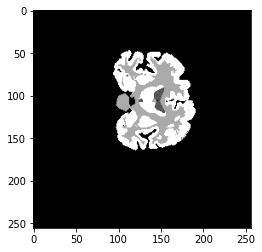

In [ ]:
tissue_model_load=nib.load('/content/drive/MyDrive/MISA_MIRA_3/combined_seg/Combined_Segmentation_1128.nii.gz')
t_m=test=tissue_model_load.get_fdata()
plt.imshow(t_m[:,128,:],cmap='gray')


In [ ]:
np.unique(t_m)

array([0., 1., 2., 3.])

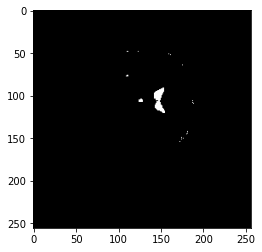

In [ ]:
CSF_label=1
GM_label=3
WM_label=2
CSF=(t_m == CSF_label)*1
GM=(t_m == GM_label)*1
WM=(t_m == WM_label)*1

plt.imshow(CSF[:,128,:],cmap='gray')
plt.show()

#flatten
csf_flat=CSF.flatten()
gm_flat=GM.flatten()
wm_flat=WM.flatten()
features_nonzero_pred = np.array((csf_flat[features_nonzero_row_indicies],
                                                  wm_flat[features_nonzero_row_indicies],
                                                  gm_flat[features_nonzero_row_indicies]))
y_pred= np.argmax(features_nonzero_pred, axis=0)

In [ ]:

def dice_similarity(Seg_img, GT_img,state):
    """   
    Inputs:
        Seg_img (numpy.ndarray): Segmented Image.
        GT_img (numpy.ndarray): Ground Truth Image.
        State: "nifti" if the images are nifti file
               "arr"   if the images are an ndarray
    output:
        Dice Similarity Coefficient: dice_CSF, dice_GM, dice_WM."""
        
    import numpy as np
    if (state=="nifti"):
       segmented_data = Seg_img.get_data().copy()
       groundtruth_data = GT_img.get_data().copy()
    elif (state=="arr"):
       segmented_data = Seg_img.copy()
       groundtruth_data = GT_img.copy()
    
    #Calculte DICE
    def dice_coefficient(SI,GT):
        #   2 * TP / (FN + (2 * TP) + FP)
        intersection = np.logical_and(SI, GT)
        return 2. * intersection.sum() / (SI.sum() + GT.sum())
    
    #Dice  for CSF
    Seg_CSF = (segmented_data == 1)
    GT_CSF = (groundtruth_data == 1)
    dice_CSF = dice_coefficient(Seg_CSF, GT_CSF)
    #Dice  for GM
    Seg_GM = (segmented_data == 2)
    GT_GM = (groundtruth_data == 2)
    dice_GM = dice_coefficient(Seg_GM, GT_GM)
    #Dice  for WM
    Seg_WM = (segmented_data == 3)
    GT_WM = (groundtruth_data == 3)
    dice_WM = dice_coefficient(Seg_WM, GT_WM)
    
    return dice_CSF, dice_GM, dice_WM

EM

In [ ]:
# intialize EM algorithm
class0 = features_nonzero[np.argwhere(y_pred == 0)[:,0]]
class1 = features_nonzero[np.argwhere(y_pred == 1)[:,0]]
class2 = features_nonzero[np.argwhere(y_pred == 2)[:,0]]
  # Compute mean and variance of each class
mean0 = np.mean(class0, axis = 0)
mean1 = np.mean(class1, axis = 0)
mean2 = np.mean(class2, axis = 0)
cov0 = np.cov(class0, rowvar = False)
cov1 = np.cov(class1, rowvar = False)
cov2 = np.cov(class2, rowvar = False)
# Class distribution
a0 = class0.shape[0] / features_nonzero.shape[0]
a1 = class1.shape[0] / features_nonzero.shape[0]
a2 = class2.shape[0] / features_nonzero.shape[0]

# Compute Gaussian mixture model for each point
p0 = gaussian_mixture(features_nonzero,  mean = mean0, cov = cov0)
p1 = gaussian_mixture(features_nonzero,  mean = mean1, cov = cov1)
p2 = gaussian_mixture(features_nonzero,  mean = mean2, cov = cov2)

# # Compute membership weight for each point
weight = membership_weight(p0, p1, p2, a0, a1, a2)
weights= np.multiply(weight,z)
 # get initial log-likelihood
log_likelihood = get_log_likelihood((a0, a1, a2), (p0, p1, p2))

In [ ]:
n_steps = 0

while True:
  # Maximization step: Use that classification to reestimate the parameters
                # Class distribution
  counts = np.sum(weights, axis=0)
  a0 = counts[0] / len(features_nonzero)
  a1 = counts[1] / len(features_nonzero)
  a2 = counts[2] / len(features_nonzero)


# Calculate mean and covariance for new classes
  mean0 = (1/counts[0]) * (weights[:, 0] @ features_nonzero)
  mean1 = (1/counts[1]) * (weights[:, 1] @ features_nonzero)
  mean2 = (1/counts[2]) * (weights[:, 2] @ features_nonzero)
  cov0 = (1/counts[0]) * ((weights[:, 0] * (features_nonzero - mean0)) @ (features_nonzero - mean0))
  cov1 = (1/counts[1]) * ((weights[:, 1] * (features_nonzero - mean1)) @ (features_nonzero - mean1))
  cov2 = (1/counts[2]) * ((weights[:, 2] * (features_nonzero - mean2)) @ (features_nonzero - mean2))

  p0 = gaussian_mixture(features_nonzero,  mean = mean0, cov = cov0)
  p1 = gaussian_mixture(features_nonzero,  mean = mean1, cov = cov1)
  p2 = gaussian_mixture(features_nonzero,  mean = mean2, cov = cov2)


# Compute membership weight for each point
  weights = membership_weight(p0, p1, p2, a0, a1, a2)
  log_likelihood_new = get_log_likelihood((a0, a1, a2), (p0, p1, p2))

  dist_change = abs((log_likelihood_new - log_likelihood) / log_likelihood)
  print("********************************************************************")
  #print(f"Img {f}")
  print("Step %d" % n_steps)
  print("Distribution change %f" % dist_change)
  print(a0, a1, a2)

  n_steps += 1

  
# check whether we reached desired precision or max number of steps
  if (n_steps >= MAX_STEPS) or (dist_change <= min_change):
      print("Loop stopped")
      break
  else:
      log_likelihood = log_likelihood_new
y_pred = np.argmax(weights, axis=1)+1
y_pred

********************************************************************
Step 0
Distribution change 0.084094
0.010351533961215548 0.17555753891399578 0.32355762355997897
********************************************************************
Step 1
Distribution change 0.079367
0.01699255064614955 0.33367033729227774 0.6493371120613468
********************************************************************
Step 2
Distribution change 0.000250
0.015909073987695206 0.3299840037727081 0.6541069222396725
Loop stopped


array([3, 3, 3, ..., 3, 3, 3])

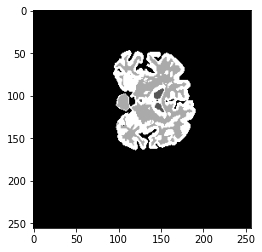

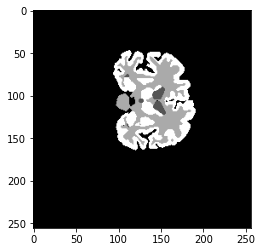

In [ ]:
# Recontruction of the image
# =============================================================================
shape_original_image=test_masked.shape
shape_flatten=features.shape
segmented_image=np.zeros(shape_flatten)
segmented_image[features_nonzero_row_indicies]=y_pred
Seg=np.reshape(segmented_image,shape_original_image)

plt.imshow(Seg[:,128,:], cmap='gray')
plt.show()
plt.imshow(gt[:,128,:], cmap='gray')
plt.show()

In [ ]:
print(np.unique(gt))
print(np.unique(y_pred))
####CALCULATINg DICE
dice_CSF, dice_GM, dice_WM = dice_similarity(Seg,gt,"arr")
print("CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))

[0. 1. 2. 3.]
[1 2 3]
CSF DICE = 0.635101626413105 GM DICE = 0.8421554725135159 WM DICE = 0.8964742565532735
